The data from this exercise comes from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation For more details on the data set see the included documentation.

In [4]:
# Ensure that Aequitas dependency is installed
!pip install aequitas==0.42 sklearn -q

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [5]:
# Imports
from aequitas.plotting import Plot
ap = Plot()
import pandas as pd
import seaborn as sns

from aequitas.group import Group
from aequitas.bias import Bias 
from aequitas.fairness import Fairness

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, label_binarize, LabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [25]:
# I manually added the headers to the data set.
df = pd.read_csv("data/car.csv")

# We'll modify the data to make it a binary problem of acceptable or unacceptable car.
df = df.where(df != 'good', 'acc')
df = df.where(df != 'vgood', 'acc')

# Save the car column in the y dataframe.
y = df.pop('car')

# Save the remaining columns in the X dataframe.
X = df

X.head()

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [20]:
df['buying'].value_counts()

high     432
vhigh    432
low      432
med      432
Name: buying, dtype: int64

In [19]:
X['safety'].value_counts()

high    576
low     576
med     576
Name: safety, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

# Use this later to construct the DataFrame Aequitas requires.
df_aq = X_test.copy()

ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
X_train = ohe.fit_transform(X_train.values)
X_test = ohe.transform(X_test.values)

lb = LabelBinarizer()
y_train = label_binarize(y_train.values, classes=['unacc', 'acc']).ravel()
y_test = label_binarize(y_test.values, classes=['unacc', 'acc']).ravel()

X_train shape:  (1296, 6)
X_test shape:  (432, 6)


In [8]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

scores = lr.predict_proba(X_test)
pred = lr.predict(X_test)

f1 = f1_score(y_test, pred)
print(f"F1 score: {f1:.4f}")

F1 score: 0.8960


In [9]:
# Construct the dataframe that Aequitas will use.
# You can draw inspiration from examples present here: https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb 

In [10]:
by_safety = df_aq[df_aq.safety.isin(['low', 'med', 'high'])]

In [30]:
aq_palette = sns.diverging_palette(100, 200, n=4)
aq_palette = sns.crayon_palette(["Red","Green","Blue","Yellow"])

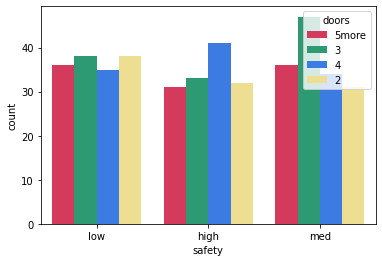

In [32]:
by_doors = sns.countplot(x="safety", hue="doors", data=by_safety, palette=aq_palette)


In [11]:
# Run Aequitas.
# Summarize: Aequitas classes provides a few functions that provide a high level summary of fairness and disparity, such as 
# plot_fairness_group_all()
# plot_fairness_disparity_all()
# plot_disparity_all()
